In [1]:
# for reading writing and visulaizing the image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for creating the model
import torch
import torchvision
from time import time
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchsummary import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
data = pd.read_csv('C:\\Users\\Ayush\\Desktop\\ML PROJECTS\\digit-recognizer\\data\\train.csv').iloc[:,1:].values
data = torch.tensor(data)
data.shape

torch.Size([42000, 784])

In [4]:
train_loader = DataLoader(data,batch_size=64,shuffle=False)

In [5]:
print(next(iter(train_loader)).shape)
next(iter(train_loader))

torch.Size([64, 784])


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [6]:
def PlotBatch(data_loader, batch_size = 16):
  batch = next(iter(data_loader))  # first batch of data_loader
  fig = plt.figure(figsize=(16,4))
  for i in range(16):
    fig.add_subplot(2,8,i+1)
    temp = batch[i,:]
    plt.imshow(temp.reshape(28,28), cmap='gray')
    plt.title(batch[i,0].item())
    plt.axis('off')

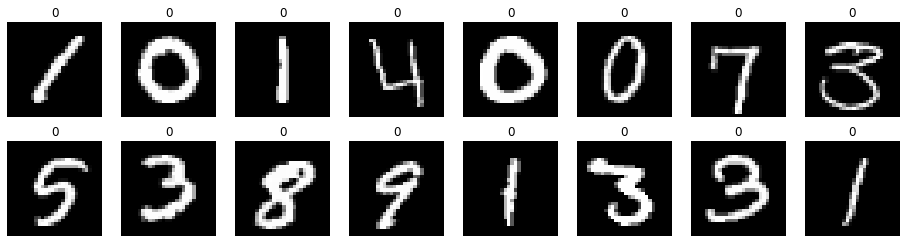

In [7]:
PlotBatch(train_loader,batch_size=64)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self,in_channels=1):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            # shape is (1,28,28)
            nn.Conv2d(in_channels=in_channels,out_channels=16,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # shape is (16,14,14)
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),
            # shape is (32,7,7)
            nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
            # shape is (32,7,7)
        ).to(device)
        self.decoder = nn.Sequential(
            # shape is (32,7,7)
            nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=2,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # shape is (16,14,14)
            nn.ConvTranspose2d(in_channels=16,out_channels=in_channels,kernel_size=2,stride=2),
            nn.Tanh()
            # shape is (1,28,28)
        ).to(device)
        
    def forward(self,x):
        # shape of x is (1,28,28)
        op = self.encoder(x)
        op = self.decoder(op)
        return op

In [9]:
model = Autoencoder().to(device)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 32, 7, 7]           9,248
      BatchNorm2d-10             [-1, 32, 7, 7]              64
             ReLU-11             [-1, 32, 7, 7]               0
  ConvTranspose2d-12           [-1, 16, 14, 14]           2,064
      BatchNorm2d-13           [-1, 16, 14, 14]              32
             ReLU-14           [-1, 16,

In [10]:
batch_size = 64
lr = 1e-2
epochs = 5
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [11]:
def train(epochs):
    LOSS = []
    for epoch in range(1,epochs+1):
        total_loss = 0
        for i,batch in enumerate(train_loader,1):
            model_input = (batch/255.0 + torch.randn(batch.shape)*3e-1).to(device)
            model_input = model_input.reshape(batch.shape[0],1,28,28)
            model_output = model(model_input)
            loss = criterion(model_output,model_input)
            total_loss+= loss.item()
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if i%200==0:
                print('Epoch [{}] ({}/{}), train_loss = {:.4f}'.format(epoch, i, len(train_loader), loss.item()))    
        print("\n")
        LOSS.append(total_loss)
    return LOSS

In [13]:
losses = train(epochs)

Epoch [1] (200/657), train_loss = 0.0696
Epoch [1] (400/657), train_loss = 0.0626
Epoch [1] (600/657), train_loss = 0.0587


Epoch [2] (200/657), train_loss = 0.0564
Epoch [2] (400/657), train_loss = 0.0554
Epoch [2] (600/657), train_loss = 0.0546




KeyboardInterrupt: 

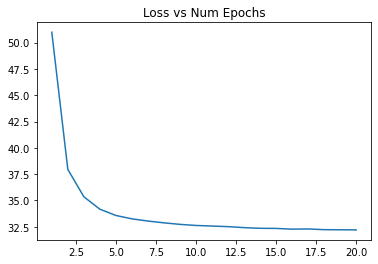

In [13]:
plt.plot(range(1,epochs+1),losses)
plt.title("Loss vs Num Epochs")
plt.show()

In [14]:
a = next(iter(train_loader))[0]
a = a.numpy()
a = (a/255.0).reshape(28,28)

### Actual Image

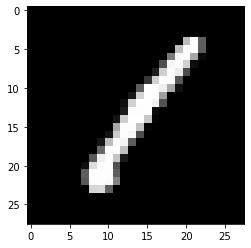

In [15]:
# showing actual image
plt.imshow(a,cmap='gray')
plt.show()

### Noised Image

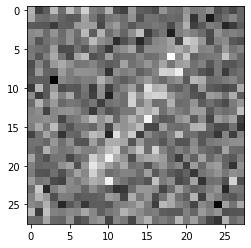

In [20]:
# showing noised image
noise = np.random.randn(28,28)*6e-1
temp = a+noise
plt.imshow(temp,cmap='gray')
plt.show()

### Denoised Image

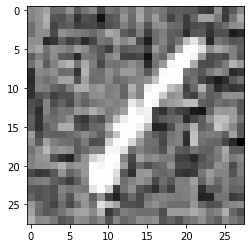

In [21]:
# showing denoised image
temp = a.reshape(1,1,28,28)
noise = np.random.randn(1,1,28,28)*3e-1
temp = temp+noise
temp = temp.astype(np.float32)
temp = torch.tensor(temp)
temp = temp.to(device)
temp = model(temp)
temp = temp.cpu().detach().numpy()
temp = temp.reshape(28,28)
plt.imshow(temp,cmap='gray')
plt.show()